# Na analysis (run 3614)

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import os
import sys
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline


import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

from invisible_cities.core.core_functions import timefunc, flat
from invisible_cities.reco.pmaps_functions import width, integrate_charge

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')


from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 

from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Tue Apr 18 15:17:02 2017


#### General plotting options

In [2]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [3]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

### Run

In [4]:
run_number = 3614

### Input data

In [9]:
# Comment out this line if your data is in $IC_DATA
#ifile = os.path.expandvars("/Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5")
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/dst_3614.root.h5'.format(run_number))
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3614/dst_3614.root.h5


# Read data

In [10]:
full = load_dst(ifile)
print(len(full))
full.head()

453713


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105


### Trigger rate and z distribution 

In [11]:
r = event_rate(full)

In [12]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 2.01149686705759 evts/s


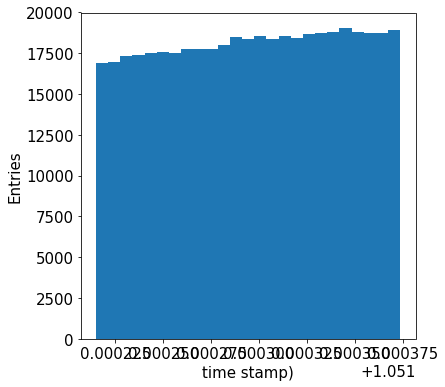

In [13]:
hist(full.time/1.419e+9, 25)
labels("time stamp)", "Entries")

In [14]:
t = full.time.values - full.time.values[0]

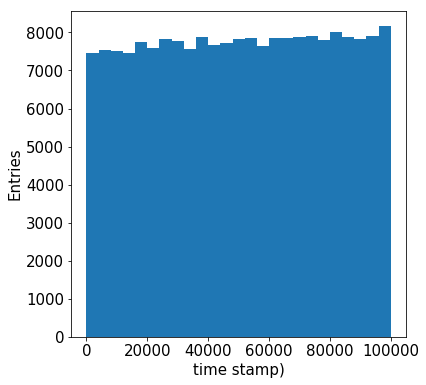

In [15]:
hist(t, 25, (0,1e+5))
labels("time stamp)", "Entries")

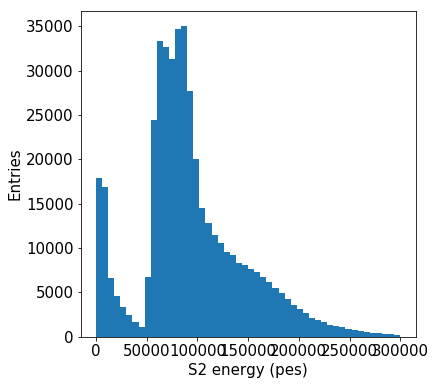

In [16]:
hist(full.S2e, 50, (0e3,3e5))
labels("S2 energy (pes)", "Entries")

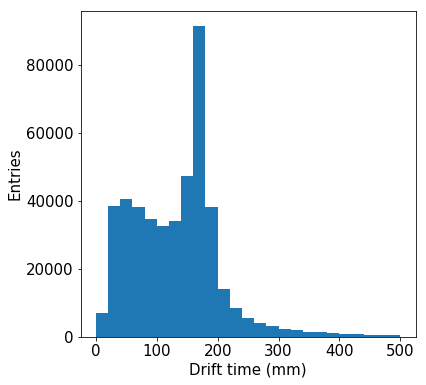

In [17]:
hist(full.Z, 25, (0,500))
labels("Drift time (mm)", "Entries")

#### Select PE enriched interactions by requiring 2 S2s 
1. PE interactions produce 80% of the time an X-ray
2. Electrons produced by Compton interactions will also produce an X-ray.
3. X rays from PE will tend to be at the interaction vertex, while X rays from Compton are produced along the electron trajectory. 

In [18]:
s2eq2 = full[full.nS2 ==2]
print("Length of data set = {}".format(len(s2eq2)))
print("RatioΩ:", len(s2eq2)/len(full))
s2eq2.head()

Length of data set = 95914
RatioΩ: 0.2113979542133463


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105
17,20,1.491674e+09,0,2,225.0,37.718376,217.355925,530875.0,36.222500,11878.065430,...,655912.5,59,125.0375,125.0375,48.661950,-86.593677,99.330007,-1.058819,27.819668,13.258652
18,20,1.491674e+09,1,2,225.0,37.718376,217.355925,530875.0,37.557875,4042.697510,...,936162.5,21,405.2875,405.2875,-175.367060,-88.570991,196.464821,-2.673905,9.955684,10.491740
32,38,1.491674e+09,0,2,150.0,14.287548,67.987579,606650.0,11.080000,12572.112305,...,657387.5,18,50.7375,50.7375,22.448518,-94.719632,97.343437,-1.338090,8.182807,8.481033


In [19]:
PE = s2eq2[s2eq2.peak ==0]
XR = s2eq2[s2eq2.peak ==1]

#### Z distribution

In [20]:
def histos(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


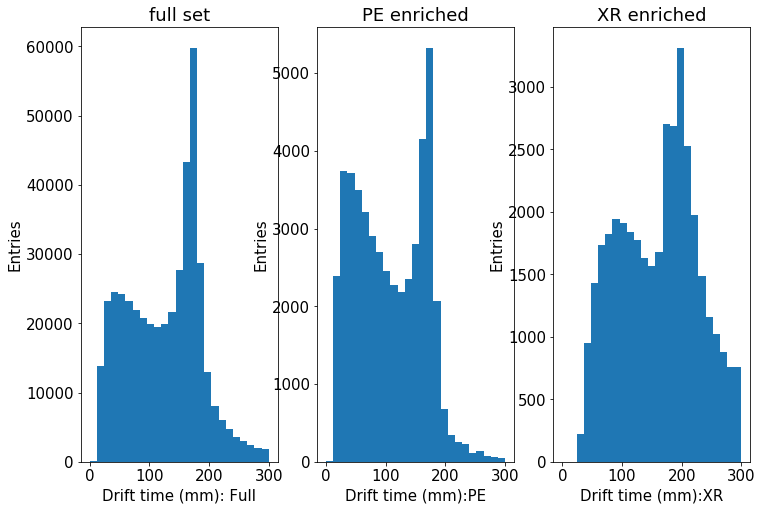

In [21]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.Z, 25, (0,300))
labels("Drift time (mm): Full", "Entries")
plt.title('full set')
ax = plt.subplot(1, 3, 2)
plt.hist(PE.Z, 25, (0,300))
labels("Drift time (mm):PE", "Entries")
plt.title('PE enriched')
ax = plt.subplot(1, 3, 3)
plt.hist(XR.Z, 25, (0,300))
labels("Drift time (mm):XR", "Entries")
plt.title('XR enriched')

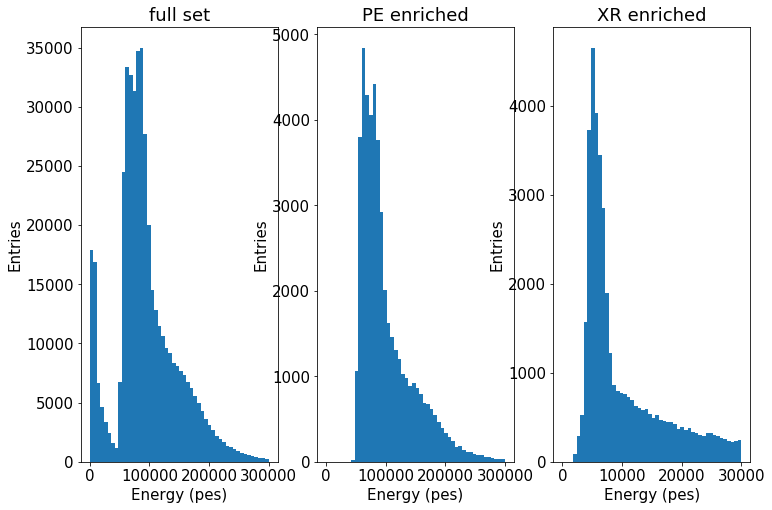

In [22]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0,300e+3))
labels("Energy (pes)", "Entries")
plt.title('full set')
ax = plt.subplot(1, 3, 2)
plt.hist(PE.S2e, 50, (0,300e+3))
labels("Energy (pes)", "Entries")
plt.title('PE enriched')
ax = plt.subplot(1, 3, 3)
plt.hist(XR.S2e, 50, (0,30e+3))
labels("Energy (pes)", "Entries")
plt.title('XR enriched')

### Zoom into PE region

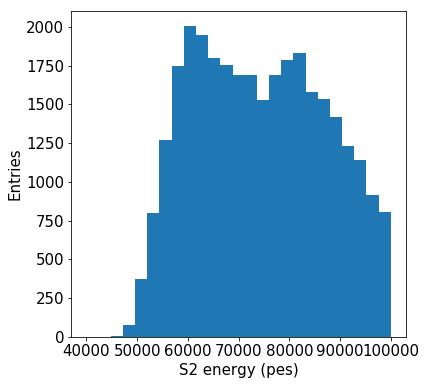

In [23]:
hist(PE.S2e, 25, (40e3,1e5))
labels("S2 energy (pes)", "Entries")

#### Where to espect the peaks

In [24]:
peak_name = ['Krypton', 'Na-22-XR', 'Na-22-511', 'Na-22-1275', 'Na-22-Compton']
peak_energy = {'Krypton':41.5, 'Na-22-XR':30, 'Na-22-511':511,'Na-22-1275':1275, 'Na-22-Compton':150}
KrE = 7400
for peak in peak_name:
    print('for peak name = {} with energy {} keV, expect {} PES'.format(
    peak, peak_energy[peak], KrE * (peak_energy[peak]/peak_energy['Krypton']) ))

for peak name = Krypton with energy 41.5 keV, expect 7400.0 PES
for peak name = Na-22-XR with energy 30 keV, expect 5349.3975903614455 PES
for peak name = Na-22-511 with energy 511 keV, expect 91118.07228915663 PES
for peak name = Na-22-1275 with energy 1275 keV, expect 227349.39759036142 PES
for peak name = Na-22-Compton with energy 150 keV, expect 26746.98795180723 PES


#### S1 to S2:

In [25]:
125*(1275./511)

311.8884540117417

#### E-Z correlation

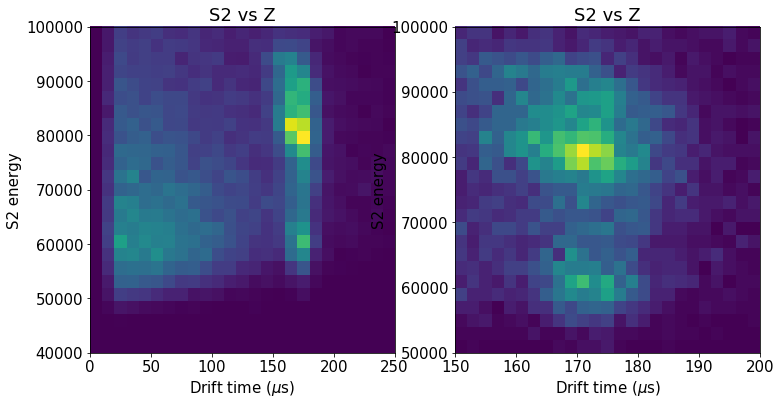

In [26]:
zrange =   0, 250
Erange = 4e4, 1e5

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(PE.Z, PE.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

zrange =   150, 200
Erange = 5e4, 1e5

ax = plt.subplot(1, 2, 2)
plt.hist2d(PE.Z, PE.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')



#### S1

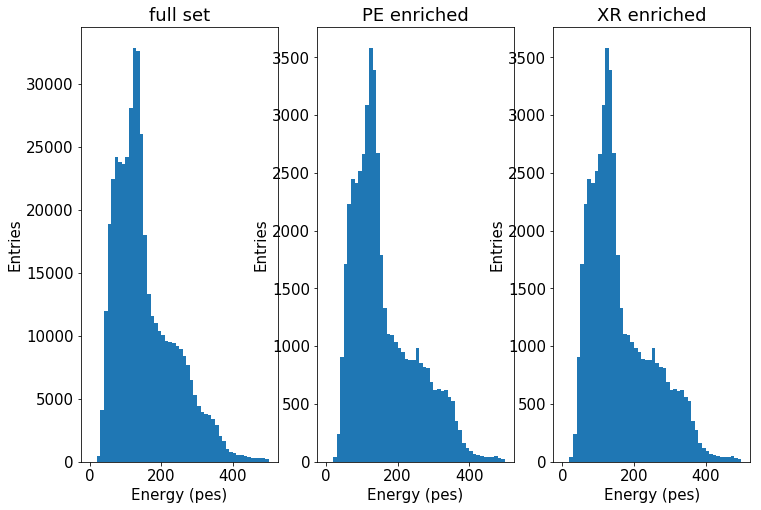

In [27]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S1e, 50, (0,500))
labels("Energy (pes)", "Entries")
plt.title('full set')
ax = plt.subplot(1, 3, 2)
plt.hist(PE.S1e, 50, (0,500))
labels("Energy (pes)", "Entries")
plt.title('PE enriched')
ax = plt.subplot(1, 3, 3)
plt.hist(XR.S1e, 50, (0,500))
labels("Energy (pes)", "Entries")
plt.title('XR enriched')

#### S1 S2 correlation

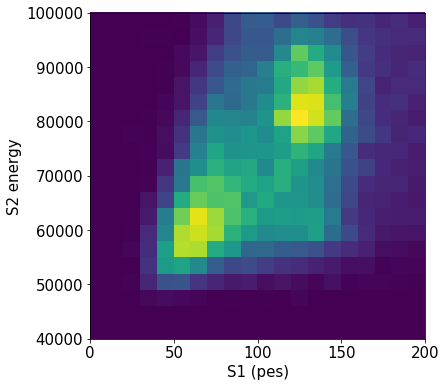

In [28]:
S1range =   0, 200
Erange = 4e4, 1e5
hist2d(PE.S1e, PE.S2e, (20, 20), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")



#### The two regions of high density in the correlation plot above correspond to PE peak and Compton shoulder (which is cutoff by the trigger)

####  Gamma of 1275?

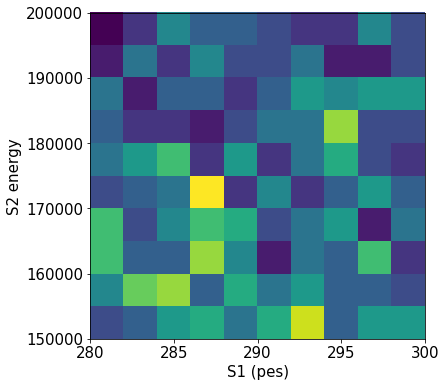

In [29]:
S1range =   280, 300
Erange = 150e3, 200e3
hist2d(PE.S1e, PE.S2e, (10, 10), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")


####  X rays

In [30]:
XR = s2eq2[s2eq2.peak ==1]
print("Ratio:", len(XR)/len(full))

Ratio: 0.10569897710667316


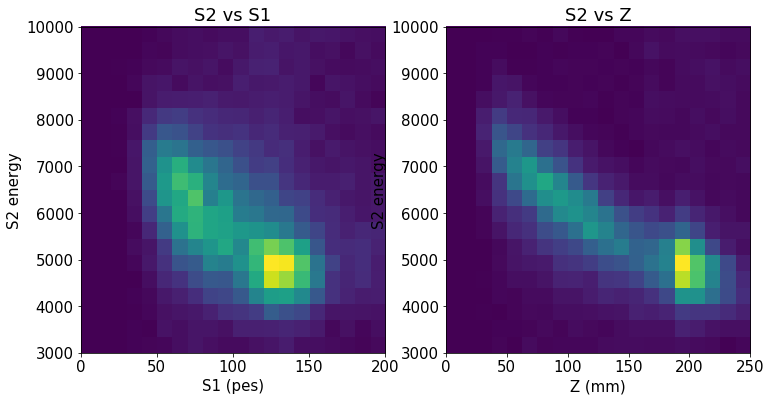

In [31]:
S1range =   0, 200
Erange = 3e3, 10e3
zrange =   0, 250

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(XR.S1e, XR.S2e, (20, 20), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")
plt.title('S2 vs S1')

ax = plt.subplot(1, 2, 2)
plt.hist2d(XR.Z, XR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z')


#### The plot above shows two components, one due to PE (S1 ~125 pes) and the other due to X rays emitted by Compton electrons with S1 in the range 50-125. This correlation plot also shows in position.

#### One can select the PE/Compton part cutting on S1

In [32]:
peXR = XR[XR.S1e >100]
print("Ratio wrt XE:", len(peXR)/len(XR))

Ratio wrt XE: 0.7394332422795421


In [33]:
cXR = XR[XR.S1e <100]
print("Ratio wrt XE:", len(cXR)/len(XR))

Ratio wrt XE: 0.2605667577204579


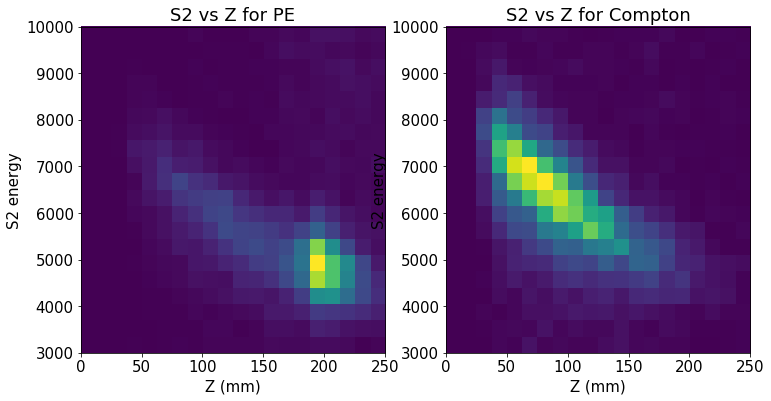

In [34]:
Erange = 3e3, 10e3
zrange =   0, 250

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(peXR.Z, peXR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z for PE')

ax = plt.subplot(1, 2, 2)
plt.hist2d(cXR.Z, cXR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z for Compton')

#### One can use the Z dependence of "Compton-produced" X rays to measure electron lifetime. But notice also the different XY distributions.

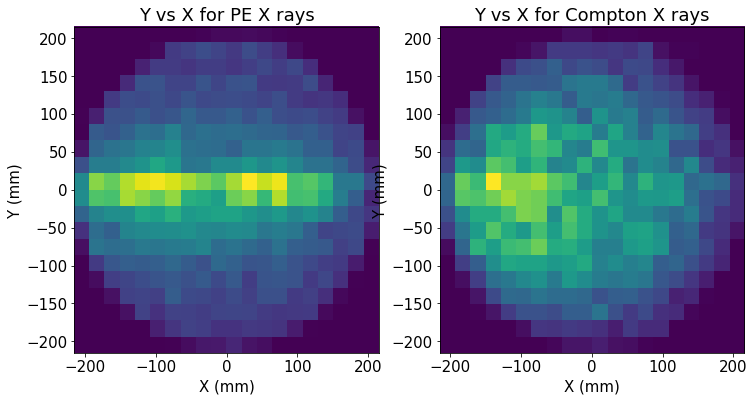

In [35]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist2d(peXR.X, peXR.Y, (20, 20), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for PE X rays')

ax = plt.subplot(1, 2, 2)
plt.hist2d(cXR.X, cXR.Y, (20, 20), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for Compton X rays')

#### PE X rays are produced more or less symmetrically through the across the line of interaction of gammas, while Compton X rays are produced by compton electrons moving towards negative X and are more spread in Y. 

### Profile histograms and fits

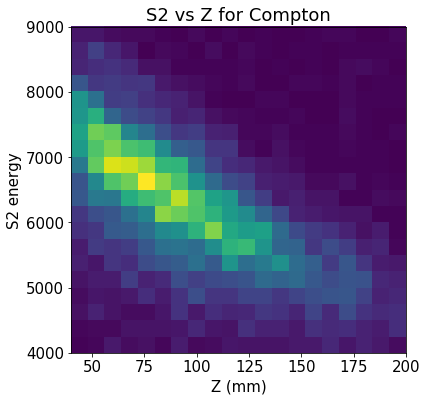

In [36]:
Erange = 4e3, 9e3
zrange =   40, 200

plt.hist2d(cXR.Z, cXR.S2e, (20, 20), range=(zrange, Erange))
labels("Z (mm)", "S2 energy")
plt.title('S2 vs Z for Compton')

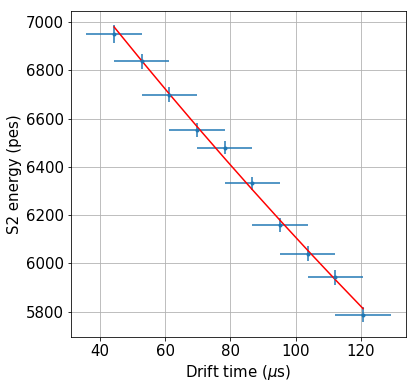

In [37]:
zrange =   40, 125
Erange = 4e+3, 8e3
nbins = 10
F, x, y, sy = profile_and_fit(cXR.Z.values, cXR.S2e.values, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=10, 
                    fitpar=(8e+3,-200), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

In [38]:
print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

fit par[0] = 7758.840603337712 error = 36.225233915529465
fit par[1] = -418.04938718633525 error = 9.692877330623416
degrees of freedom = 2
chi2 = 0.788040856843303


#### Fiducialize

#### Thus, lifetime = 418 +- 11 mus

#### We now apply the correction to the full crXR set

In [39]:
zfun  = F.fn
zmin  = np.min(z)
zcorr = lambda z: zfun(zmin)/zfun(z)

NameError: name 'z' is not defined

In [40]:
Erange = 4e+3, 11e3
Ez = cXR.S2e * zcorr(cXR.Z)

NameError: name 'zcorr' is not defined

NameError: name 'Ez' is not defined

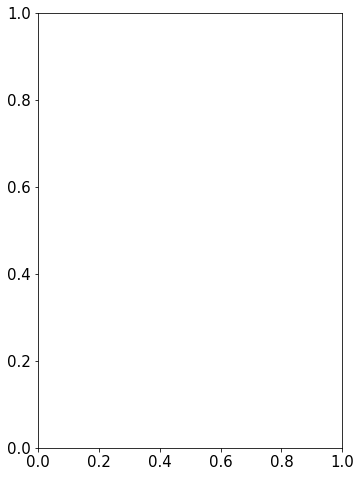

In [41]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(crXR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E uncorrected')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 5000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))


In [42]:
zrange =   40, 120
Erange = 4e+3, 8e3
nbins = 9
F2, x, y, sy = profile_and_fit(cXR.Z.values, Ez, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=10, 
                    fitpar=(8e+3,-10), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

NameError: name 'Ez' is not defined

In [43]:
print_fit(F2)
print('chi2 = {}'.format(chi2(F2, x, y, sy)))

NameError: name 'F2' is not defined

In [44]:
zfun2  = F2.fn
zcorr2 = lambda z: zfun2(zmin)/zfun2(z)

NameError: name 'F2' is not defined

NameError: name 'zcorr' is not defined

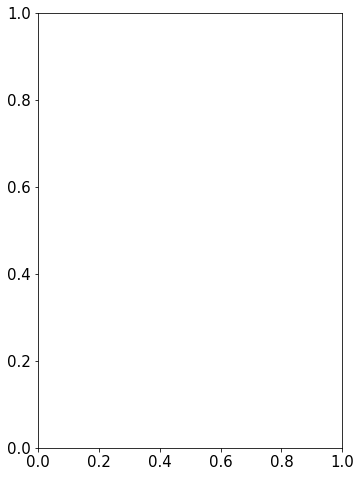

In [45]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.plot(x, zcorr(x))
plt.title('first order correction function')

ax = plt.subplot(1, 2, 2)
plt.plot(x, zcorr2(x))
plt.title('second order correction function')

In [46]:
Erange = 4e+3, 11e3
Ez2 = cXR.S2e * zcorr(cXR.Z) * zcorr2(cXR.Z)

NameError: name 'zcorr' is not defined

NameError: name 'Ez' is not defined

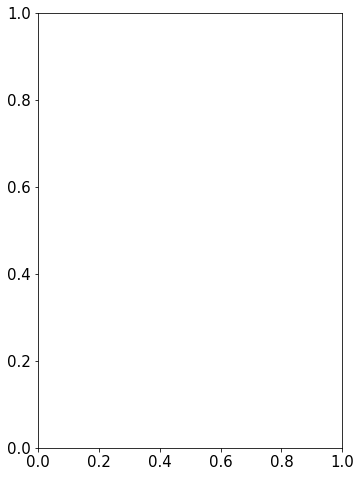

In [47]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (first order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(Ez2, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (second order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7400, 9400)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

### Geometrical corrections

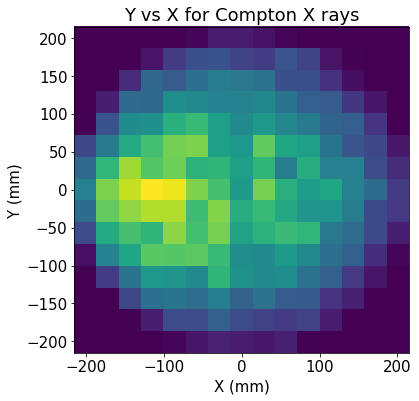

In [48]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(cXR.X, cXR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for Compton X rays')

In [49]:
cXR_x1 = cXR[cXR.X < -70 ]
cXR_x2 = cXR_x1[cXR_x1.X > -130 ]
crXR = cXR_x2[abs(cXR_x2.Y) < 20 ]
print("Ratio wrt cXR:", len(crXR)/len(cXR))

Ratio wrt cXR: 0.037371959026888606


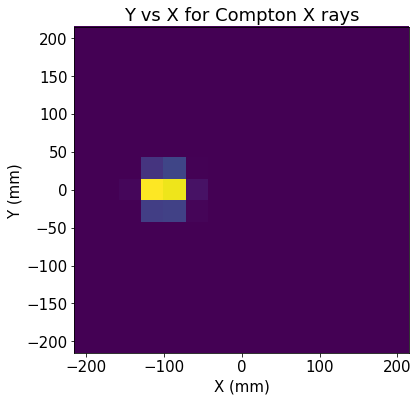

In [50]:
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(crXR.X, crXR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for Compton X rays')

In [51]:
Erange = 4e+3, 11e3
Ez2 = crXR.S2e * zcorr(crXR.Z) 

NameError: name 'zcorr' is not defined

NameError: name 'Ez' is not defined

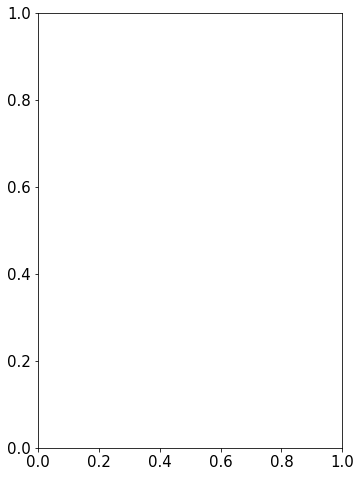

In [52]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (first order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(Ez2, 25, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (second order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))
         

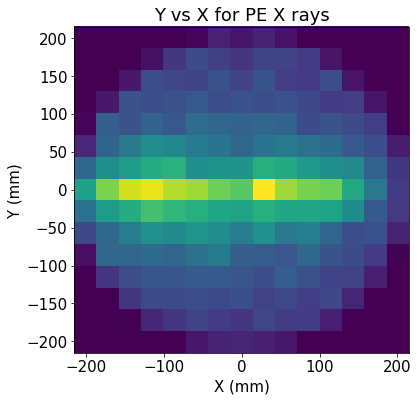

In [53]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(peXR.X, peXR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for PE X rays')

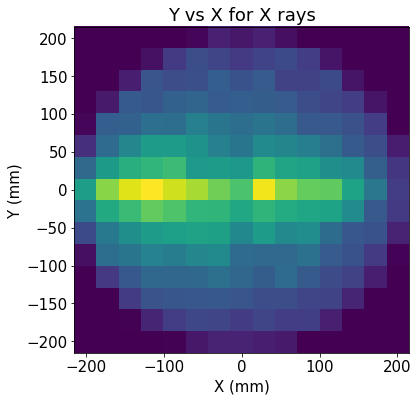

In [54]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(XR.X, XR.Y, (15, 15), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for X rays')

In [55]:
fXR = XR[XR.R < 180 ]
print("Ratio wrt cXR:", len(fXR)/len(XR))

Ratio wrt cXR: 0.8499072085409847


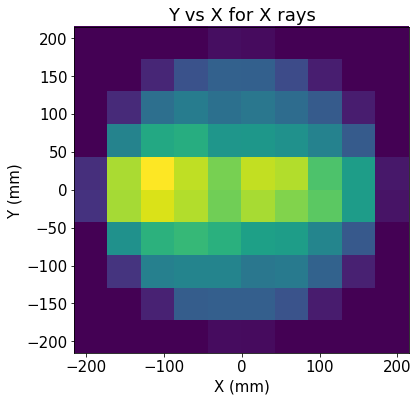

In [56]:
xrange=-215, 215
yrange=-215, 215
plot_options(figsize=(6,6), fontsize=15)
ax = plt.subplot(1, 1, 1)
plt.hist2d(fXR.X, fXR.Y, (10, 10), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X for X rays')

In [57]:
Erange = 4e+3, 11e3
Ez = fXR.S2e * zcorr(fXR.Z) 
Ez2 = XR.S2e * zcorr(XR.Z) 

NameError: name 'zcorr' is not defined

NameError: name 'Ez' is not defined

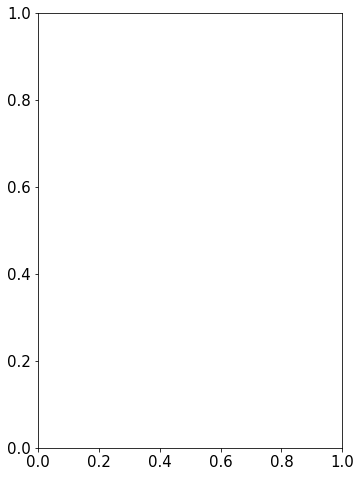

In [58]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (fiducial)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)

y, x, _ = plt.hist(Ez2, 25, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (full)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [59]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = XR.S2e * zcorr(XR.Z)

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

NameError: name 'zcorr' is not defined

In [60]:
_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")

NameError: name 'E' is not defined

In [61]:
hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

NameError: name 'E' is not defined

In [62]:
hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")

NameError: name 'E' is not defined

In [63]:
def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

NameError: name 'pf' is not defined

In [64]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3
#Erange = 6500, 7500
E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 7e3, 5e2), fit_range=(6500, 8000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")

NameError: name 'zcorr' is not defined

In [65]:




hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

NameError: name 'E' is not defined

NameError: name 'Ez2' is not defined

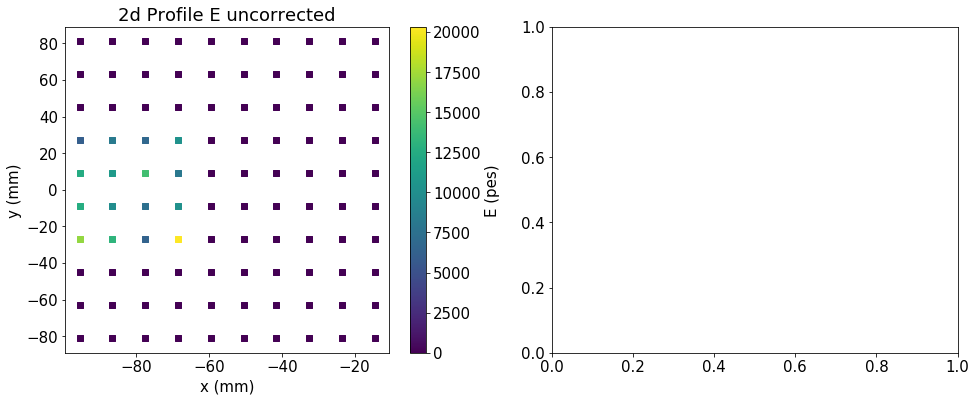

In [66]:
xrange = -100, -10
yrange = -90, 90
nbin = (10,10)
figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

x, y, E, Ee = fitf.profileXY(crXR.X, crXR.Y, crXR.S2e, *nbin, xrange=xrange, yrange=yrange)
x_ = np.repeat(x, x.size)
y_ = np.tile  (y, y.size)
z_ = E.flatten()
plt.scatter(x_, y_, c=z_, marker="s") 
cb = plt.colorbar()
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E uncorrected')

ax = plt.subplot(1, 2, 2)
x, y, E, Ee = fitf.profileXY(crXR.X, crXR.Y, Ez2, *nbin, xrange=xrange, yrange=yrange)
x_ = np.repeat(x, x.size)
y_ = np.tile  (y, y.size)
z_ = E.flatten()
plt.scatter(x_, y_, c=z_, marker="s") 
cb = plt.colorbar()
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E corrected')


In [ ]:
E

In [ ]:
eref = E[E.shape[0]//2, E.shape[1]//2]

In [67]:
eref

NameError: name 'eref' is not defined

In [68]:
x

array([-95.5, -86.5, -77.5, -68.5, -59.5, -50.5, -41.5, -32.5, -23.5, -14.5])

In [69]:
y

array([-81., -63., -45., -27.,  -9.,   9.,  27.,  45.,  63.,  81.])

In [70]:
class XYCorr:
    def __init__(self, x, y, e):
        self.xs = x.reshape(x.size, 1)
        self.ys = y.reshape(y.size, 1)
        eref = e[e.shape[0]//2, e.shape[1]//2]
        self.es = e / eref
        print(self.es)
    def xycorr(self, x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x - self.xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y - self.ys))
        return self.es[x_closest, y_closest]
        
        

In [71]:
xyc = XYCorr(x, y, E)

[[ nan  nan  nan  inf  inf  inf  inf  nan  nan  nan]
 [ nan  nan  nan  inf  inf  inf  inf  nan  nan  nan]
 [ nan  nan  nan  inf  inf  inf  inf  nan  nan  nan]
 [ nan  nan  nan  inf  inf  inf  inf  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]


/Users/alej/miniconda/envs/IC3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/Users/alej/miniconda/envs/IC3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


In [72]:
xyc.xs

array([[-95.5],
       [-86.5],
       [-77.5],
       [-68.5],
       [-59.5],
       [-50.5],
       [-41.5],
       [-32.5],
       [-23.5],
       [-14.5]])

In [73]:
xyc.ys

array([[-81.],
       [-63.],
       [-45.],
       [-27.],
       [ -9.],
       [  9.],
       [ 27.],
       [ 45.],
       [ 63.],
       [ 81.]])

In [74]:
x_closest = np.apply_along_axis(np.argmin, 0, abs(crXR.X.values - xyc.xs))

In [75]:
y_closest = np.apply_along_axis(np.argmin, 0, abs(crXR.Y.values - xyc.ys))

In [76]:
xyc.es[x_closest, y_closest]

array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  i

In [77]:
Ec  = crXR.S2e.values * zcorr(crXR.Z) * xyc.xycorr(crXR.X.values, crXR.Y.values)

NameError: name 'zcorr' is not defined

In [78]:
crXR.S2e.values * zcorr(crXR.Z.values)

NameError: name 'zcorr' is not defined

In [79]:
Ec = crXR.S2e.values * zcorr(crXR.Z.values) * xyc.es[x_closest, y_closest]

NameError: name 'zcorr' is not defined

NameError: name 'Ez' is not defined

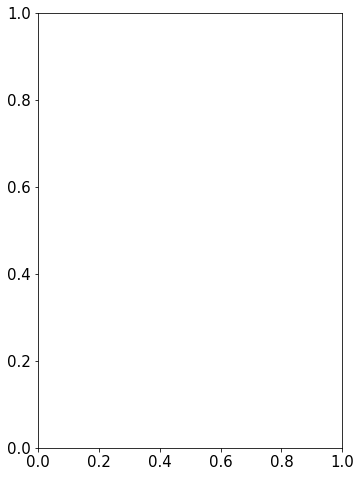

In [80]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
y, x, _ = plt.hist(Ez, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (first order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 9000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

ax = plt.subplot(1, 2, 2)
y, x, _ = plt.hist(Ec, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
plt.title('E corrected by Z (second order)')

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 7000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [ ]:
x.reshape(x.size, 1)

In [ ]:
eref = E[E.shape[0]//2, E.shape[1]//2]

In [ ]:
eref

In [ ]:
pf, _, cb = profile_and_scatter(crXR.X, crXR.Y, crXR.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E uncorrected')

ax = plt.subplot(1, 2, 2)
pf, _, cb = profile_and_scatter(crXR.X, crXR.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
plt.title('2d Profile E corrected by attachment')

x, y, z, ze = fitf.profileXY(crXR.X, crXR.Y, Ez2, *nbin, xrange=xrange, yrange=yrange)
def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

In [ ]:
peXR = XR[XR.S1e >100]
print("Ratio wrt XE:", len(peXR)/len(XR))

In [ ]:
s1cXR = XR[XR.S1e <70]
print("Ratio:", len(s1cXR)/len(full))
s1cXR.head()

In [ ]:
hist(s1cXR.S2e, 50, (0e3,1e+4))
labels("S2 energy (pes)", "Entries")

### Dependence with Z

In [ ]:
zrange =   0, 220
Erange = 4e+3, 8e3
hist2d(XR.Z, XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")



In [ ]:
zrange =   150, 220
Erange = 2e+3, 1e4
hist2d(s1XR.Z, s1XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")



#### Histogram above are supposed to be x-rays from PE interactions. They occur at a fixed position and thus, they all drift the same. 

#### Histogram below is supposed to be due to Compton-induced X rays. They are distributed 

In [ ]:
zrange =   0, 220
Erange = 2e+3, 1e+4
nbins = 10
ze = (zrange[1] - zrange[0])/nbins
hist2d(s1cXR.Z, s1cXR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")



In [ ]:
zrange =   40, 100
Erange = 4e+3, 8e3
nbins = 10
ze = (zrange[1] - zrange[0])/nbins

In [ ]:
zrange =   40, 100
Erange = 4e+3, 8e3
nbins = 10
ze = (zrange[1] - zrange[0])/nbins
z, E, Ee = fitf.profileX(s1cXR.Z.values, s1cXR.S2e.values, nbins=nbins,
             xrange=zrange, yrange=Erange, drop_nan=True)

sel  = fitf.in_range(z, zrange[0], zrange[1])
z, E, Ee = z[sel], E[sel], Ee[sel]
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

In [ ]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

In [ ]:
plt.plot(Ee)

In [ ]:
Ee = np.repeat(35,10)

In [ ]:
f = fitf.fit(fitf.expo, z, E, (1e4, -200), sigma=Ee)


In [ ]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')
plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
nevts, xs, ys, _ = \
hist2d(s1cXR.X, s1cXR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")



In [ ]:
pf, _, cb = profile_and_scatter(s1cXR.X, s1cXR.Y, s1cXR.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
zfPE1 = PE[PE.Z > 165]
zfPE = zfPE1[zfPE1.Z < 185]
print("Ratio wrt full:", len(zfPE)/len(full))
print("Ratio wrt PE:", len(zfPE)/len(PE))

In [ ]:
S1range =   0, 200
Erange = (0e3,1e+4)
hist2d(XR.S1e, XR.S2e, (25, 25), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")

In [ ]:
s1cXRx = s1cXR[s1cXR.X <0]
s1cXRxy = s1cXRx[abs(s1cXRx.Y) <100]
print("Ratio:", len(s1cXRxy)/len(full))
s1cXRxy.head()

In [ ]:
z, E, Ee = fitf.profileX(s1cXRxy.Z.values, s1cXRxy.S2e.values, nbins=nbins,
             xrange=zrange, yrange=Erange, drop_nan=True)

sel  = fitf.in_range(z, zrange[0], zrange[1])
z, E, Ee = z[sel], E[sel], Ee[sel]
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

In [ ]:
f = fitf.fit(fitf.expo, z, E, (1e4, -200), sigma=Ee)

In [ ]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')
plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

#### Large uncertainties in fit with this subset

In [ ]:
zrange =   0, 220
Erange = 4e+3, 8e3
hist2d(XR.Z, XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


In [ ]:
hist2d(XR.X, XR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")



In [ ]:
zXR1 = XR[XR.Z >40]
zXR =  zXR1[zXR1.Z < 150]
print("Ratio:", len(zXR)/len(full))
s1cXRxy.head()

In [ ]:
hist2d(zXR.X, zXR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")


In [ ]:
xzXR1 = zXR[zXR.X > -150]
xzXR =  xzXR1[xzXR1.X < -50]
xyzXR = xzXR[abs(xzXR.Y) <100]
print("Ratio:", len(xyzXR)/len(full))
xyzXR.head()

In [ ]:
hist2d(xyzXR.Z, xyzXR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

In [ ]:
zrange =   40, 150
Erange = 45e+2, 75e2
nbins = 10
ze = (zrange[1] - zrange[0])/nbins
z, E, Ee = fitf.profileX(s1cXRxy.Z.values, s1cXRxy.S2e.values, nbins=nbins,
             xrange=zrange, yrange=Erange, drop_nan=True)

sel  = fitf.in_range(z, zrange[0], zrange[1])
z, E, Ee = z[sel], E[sel], Ee[sel]
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

In [ ]:
f = fitf.fit(fitf.expo, z, E, (1e4, -200), sigma=Ee)

In [ ]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')
plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
zfun  = f.fn
zmin  = np.min(z)
zcorr = lambda z: zfun(zmin)/zfun(z)

In [ ]:
plt.plot(z, zcorr(z))

In [ ]:
Erange = 4e3, 9e3
hist(zXR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

In [ ]:
E = zXR.S2e * zcorr(zXR.Z)

In [ ]:
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

In [ ]:
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [ ]:
z2XR1 = XR[XR.Z >180]
z2XR =  z2XR1[z2XR1.Z < 220]
print("Ratio:", len(z2XR)/len(full))

In [ ]:
Erange = 2e3, 9e3
y, x, _ = hist(z2XR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 4000, 6000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 5e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [ ]:
E = z2XR.S2e * zcorr(z2XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

In [ ]:
Erange = 2e3, 9e3
y, x, _ = hist(XR.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

In [ ]:
Erange = 2e3, 10e3
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")

In [ ]:
hist(zfPE.S1e, 50, (0,200))
labels("S1 energy (pes)", "Entries")

In [ ]:
zs1fPE1 = zfPE[zfPE.S1e > 130]
zs1fPE = zs1fPE1[zs1fPE1.S1e < 150]
print("Ratio:", len(zs1fPE)/len(full))
zfPE.head()

In [ ]:
hist(zs1fPE.S2e, 25, (50e+3,100e3))
labels("S2 energy (pes)", "Entries")

In [ ]:
S1range =   0, 200
Erange = 5e4, 1e5
hist2d(zfPE.S1e, zfPE.S2e, (25, 25), range=(S1range, Erange))
labels("S1 (pes)", "S2 energy")



In [ ]:
hist(zfPE.S2e, 50, (0e3,15e4))
labels("S2 energy (pes)", "Entries")

In [ ]:
Erange = 2e3, 10e3
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

### Now take all the sample

In [ ]:
zf1 = full[full.Z > 170]
zf = full[full.Z < 172]
print("Ratio:", len(zf)/len(full))
zf.head()

In [ ]:
hist(zf.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

#### The peak now gets contributions from Compton interactions of the 1.2 MeV gamma

In [ ]:
hist(zf.S2e, 50, (2.0e5,3.0e5))
labels("S2 energy (pes)", "Entries")

In [ ]:
s2eq2p0zlt15 = s2eq2p0[s2eq2p0.Z < 150]
s2eq2p0zlt15.head()

In [ ]:
hist(s2eq2p0zlt15.Z, 25, (0,200))
labels("Drift time (mm)", "Entries")

In [ ]:
hist(s2eq2p0zlt15.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

In [ ]:
s2eq2p0zgt15 = s2eq2p0[s2eq2p0.Z > 150]
s2eq2p0zgt15.head()

In [ ]:
hist(s2eq2p0zgt15.Z, 25, (0,200))
labels("Drift time (mm)", "Entries")

In [ ]:
hist(s2eq2p0zgt15.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

In [ ]:
s2eq2p1 = s2eq2[s2eq2.peak ==1]
s2eq2p0.head()

In [ ]:
hist(s2eq2p1.Z, 25, (0,300))
labels("Drift time (mm)", "Entries")

In [ ]:
hist(s2eq2p1.S2e, 50, (0e3,1e4))
labels("S2 energy (pes)", "Entries")

In [ ]:
zrange =   0, 300
Erange = 0e3, 1e4
hist2d(s2eq2p1.Z, s2eq2p1.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

In [ ]:
XR1 = full[full.S2e > 2e3]
XR = XR1[XR1.S2e < 10e3]
print("Ratio:", len(XR)/len(full))
XR.head()

In [ ]:
hist(XR.nS2)
labels("number of S2", "Entries")

In [ ]:
hist(XR.Z, 25, (0,500))
labels("Drift time (mm)", "Entries")

In [ ]:
hist(XR.Z, 25, (0,200))
hist(full.Z, 25, (0,200))
doublehist(XR.Z, full.Z, ['XR','full'],(0,500))
labels("Drift time (mm)", "Entries")

In [ ]:
plt.figure()
h1 = plt.hist(XR.Z, 25, (0,500), label='XR', alpha=0.5, normed=True)
h2 = plt.hist(full.Z, 25,(0,500), label='Full', alpha=0.5, normed=True)
plt.legend()

In [ ]:
zrange =   0, 200
Erange = 50e3, 1e5
hist2d(full.Z, full.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


Erange =  4e3, 8e3
hist2d(XR.Z, XR.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

In [ ]:
x, xe, y, ye  = plot_profile_histogram(XR.Z.values, 
                                       XR.S2e.values, 
                                       xr = (50,200), nbins=20)

In [ ]:
len(ye)

In [ ]:
sel  = fitf.in_range(x, 60, 150)
x, y, ye = x[sel], y[sel], ye[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.errorbar(x=x, xerr=xe, y=y, yerr=ye,
                 linestyle='none', marker='.')
plt.plot(x, f.fn(x), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
plt.plot(ze)

In [ ]:
plt.errorbar(x=z, xerr=ze, y=E, yerr=Ee,
                 linestyle='none', marker='.')

plt.plot(z, f.fn(z), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")



#### NB very visible position of the source

### Raw S2

In [ ]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

In [ ]:
pdf(full.S2e, 200, (0,3e5))
labels("S2 energy (pes)", "Entries")

In [ ]:
hist(full.S2e, 50, (0e3,2e5))
labels("S2 energy (pes)", "Entries")

In [ ]:
n, bins, patches  = hist(full.S2e, 25, (0,1e4))
labels("S2 energy (pes)", "Entries")

### S1

In [ ]:
bins = np.linspace(0, 500, 100)
n, bins, patches  = hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
n, bins, patches  = hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 100, 100)
n, bins, patches  =  hist(full.S1h, bins)
labels("S1 heigth (pes)", "Entries")

### S2 energy vs Z

In [ ]:
zrange =   0, 300
Erange = 50e3, 1e5
hist2d(full.Z, full.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


Erange =  1e3, 1e4
hist2d(full.Z, full.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

### S1 energy vs Z

In [ ]:
zrange =   0, 250
Erange = 50, 250
hist2d(full.Z, full.S1e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S1 energy")

### S1 vs S2

In [ ]:
zrange =   0, 250
S1range = 50, 250
S2range = 50e3, 1e5
hist2d(full.S1e, full.S2e, (50, 50), range=(S1range, S2range))
labels("S1 energy (pes)", "S2 energy (pes)")
#save("S1_energy_vs_S2_energy_short")

In [ ]:
s1pe_l = full[full.S1e > 120]
s1pe   = s1pe_l[s1pe_l.S1e < 150]
print("Ratio:", len(s1pe)/len(full))
s1pe.head()

In [ ]:
hist(s1pe.S2e, 50, (0e3,2e5))
labels("S2 energy (pes)", "Entries")

In [ ]:
s1npe = full[full.S1e < 100]
print("Ratio:", len(s1npe)/len(full))
s1npe.head()

In [ ]:
hist(s1npe.S2e, 50, (0e3,2e5))
labels("S2 energy (pes); S1 < 100 pes", "Entries")

## Short drift time: Z < 250 $\mu$s

In [ ]:
shortZ = full[full.Z < 250]
fidz = shortZ[shortZ.Z > 50]
print("Ratio:", len(fidz)/len(full))
fidz.head()

# S2 energy

In [ ]:
zrange =   50, 250
Erange = 50e3, 1e5
hist2d(shortZ.Z, shortZ.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")


Erange =  1e3, 1e4
hist2d(shortZ.Z, shortZ.S2e, (50, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")

### X rays

In [ ]:
XR1 = fidz[fidz.S2e > 4e3]
XR = XR1[XR1.S2e < 8e3]
print("Ratio:", len(XR)/len(full))
XR.head()

### Geometry

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(XR.X, 25, range=xrange)
labels("x (mm)", "Entries")


hist(XR.Y, 25, range=yrange)
labels("y (mm)", "Entries")

hist(XR.R, 25, range=rrange)
labels("r (mm)", "Entries")

hist(XR.Phi, 25, range=prange)
labels("$\phi$ (rad)", "Entries")

nevts, xs, ys, _ = \
hist2d(XR.X, XR.Y, (20, 30), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")


In [ ]:

pf, _, cb = profile_and_scatter(XR.X, XR.Y, XR.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
rfid = 180
XRfid = XR[XR.R < rfid]
print("Ratio:", len(XRfid)/len(full))
print("Ratio:", len(XRfid)/len(XR))
XRfid.head()

In [ ]:
pf, _, cb = profile_and_scatter(XRfid.X, XRfid.Y, XRfid.S2e, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
x, xe, y, ye  = plot_profile_histogram(XRfid.Z.values, 
                                           XRfid.S2e.values, 
                                           xr = (50,160), nbins=20)

In [ ]:
sel  = fitf.in_range(x, 50, 160)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.errorbar(x=x, xerr=xe, y=y, yerr=ye,
                 linestyle='none', marker='.')
plt.plot(x, f.fn(x), fitOpt)
print('fit values: E0 = {} lifetime = {}'.format(f.values[0],f.values[1]))
print('errors: E0 = {} lifetime = {}'.format(f.errors[0],f.errors[1]))
print('chi2 = {}'.format(f.chi2))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
#('FitFunction'    , 'fn values errors chi2')):

In [ ]:
zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

In [ ]:
plt.plot(x, zcorr(x))

### Correction by attachment

### Z corr in fiducial (no hard cut on R)

In [ ]:
Erange = 4e3, 10e3
E = XR.S2e * zcorr(XR.Z)
y, x, _ = hist(E, 50, range=Erange)
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))
labels("S2 energy (pes)", "Entries")

In [ ]:
hist2d(XR.Z, E, (25, 25), range=(zrange, Erange))
labels("z(mm)", "S2 energy (pes)")

In [ ]:
Erange = 4e3, 8e3
E = XR.S2e * zcorr(XR.Z)
x, xe, y, ye  = plot_profile_histogram(XR.Z.values, 
                                           E, 
                                           xr = (50,200), nbins=20)

### Z corr in restricted fiducial (hard cut on R)

In [ ]:
Erange = 4e3, 10e3
E = fidzr.S2e * zcorr(fidzr.Z)
y, x, _ = hist(E, 25, range=Erange)
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))
labels("S2 energy (pes)", "Entries")

In [ ]:
hist2d(fidzr.Z, E, (25, 25), range=(zrange, Erange))
labels("z(mm)", "S2 energy (pes)")

### Tracking plane

In [ ]:
nrange = 0, 120

hist(fidz.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")

### Event distribution 

#### all events

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(fidz.X, 50, range=xrange)
labels("x (mm)", "Entries")

hist(fidz.Y, 50, range=yrange)
labels("y (mm)", "Entries")

hist(fidz.R, 50, range=rrange)
labels("r (mm)", "Entries")

hist(fidz.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(fidz.X, fidz.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(fidz.R, fidz.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")


In [ ]:
Erange =  4e3, 200e3

E = fidz.S2e * zcorr(fidz.Z)

pf, _, cb = profile_and_scatter(fidz.X, fidz.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
Erange =  4e3, 10e3

E = fidz.S2e * zcorr(fidz.Z)

pf, _, cb = profile_and_scatter(fidz.X, fidz.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

### Cut on R

In [ ]:
rfid = 180
fidr = fidz[fidz.R < rfid]
print("Ratio:", len(fidr)/len(full))
fidr.head()

In [ ]:
Erange =  4e3, 200e3

E = fidr.S2e * zcorr(fidr.Z)

pf, _, cb = profile_and_scatter(fidr.X, fidr.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
Erange =  60e3, 90e3

E = fidr.S2e * zcorr(fidr.Z)

pf, _, cb = profile_and_scatter(fidr.X, fidr.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
Erange =  4e3, 10e3

E = fidr.S2e * zcorr(fidr.Z)

pf, _, cb = profile_and_scatter(fidr.X, fidr.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

#### X rays

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(XR.X, 25, range=xrange)
labels("x (mm)", "Entries")

hist(XR.Y, 25, range=yrange)
labels("y (mm)", "Entries")

hist(XR.R, 25, range=rrange)
labels("r (mm)", "Entries")

hist(XR.Phi, 25, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(XR.X, XR.Y, (25, 25), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(XR.R, XR.Phi, (25, 25), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

In [ ]:
yfid = 50
fidy = fidz[abs(fidz.Y) < yfid]
print("Ratio:", len(fidy)/len(full))
fidy.head()

### After y fiducial cut

In [ ]:
xrange = -215, 215
yrange = -50, 50
rrange =    0, 215
prange = - pi,  pi

hist(fidy.X, 50, range=xrange)
labels("x (mm)", "Entries")

hist(fidy.Y, 50, range=yrange)
labels("y (mm)", "Entries")

hist(fidy.R, 50, range=rrange)
labels("r (mm)", "Entries")

hist(fidy.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(fidy.X, fidy.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(fidy.R, fidy.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

### X Rays

In [ ]:
XRyfid = 150
XRxfid = 150
fidyXR = XR[abs(XR.Y) < XRyfid]
fidXR = fidyXR[abs(fidyXR.X) < XRxfid]
print("Ratio:", len(fidXR)/len(full))
print("Ratio wr XR:", len(fidXR)/len(XR))
fidXR.head()

In [ ]:
xrange = -150, 150
yrange = -150, 150
rrange =    0, 215
prange = - pi,  pi
bins = 25

hist(fidXR.X, bins, range=xrange)
labels("x (mm)", "Entries")

hist(fidXR.Y, bins, range=yrange)
labels("y (mm)", "Entries")

hist(fidXR.R, bins, range=rrange)
labels("r (mm)", "Entries")

hist(fidXR.Phi, bins, range=prange)
labels("$\phi$ (rad)", "Entries")


nevts, xs, ys, _ = \
hist2d(fidXR.X, fidXR.Y, (20, 20), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")

################################
hist2d(fidXR.R, fidXR.Phi, (20, 20), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")

### Energy vs XY

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = fidXR.S2e * zcorr(fidXR.Z)

pf, _, cb = profile_and_scatter(fidXR.X, fidXR.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
_, _, cb = profile_and_scatter(fidXR.R, fidXR.Phi, E, (20, 20), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")

In [ ]:
XRrfid1 = 20
XRxfid2 = 160
fidyXR = XR[abs(XR.Y) < XRyfid]
fidXR = fidyXR[abs(fidyXR.X) < XRxfid]
fidr1XR = fidXR[abs(fidXR.R) > XRrfid1]
fidrXR = fidr1XR[abs(fidr1XR.R) < XRxfid2]
print("Ratio:", len(fidrXR)/len(full))
print("Ratio wr XR:", len(fidrXR)/len(XR))
fidrXR.head()

In [ ]:
xrange = -150, 150
yrange = -150, 150
rrange =    20, 160
prange = - pi,  pi
Erange =  4e3, 9e3

E = fidrXR.S2e * zcorr(fidrXR.Z)

pf, _, cb = profile_and_scatter(fidrXR.X, fidrXR.Y, E, (20, 20), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [ ]:
_, _, cb = profile_and_scatter(fidrXR.R, fidrXR.Phi, E, (20, 20), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")

In [ ]:
XRrfid1 = 10
XRxfid2 = 100
fidyXR = XR[abs(XR.Y) < XRyfid]
fidXR = fidyXR[abs(fidyXR.X) < XRxfid]
fidr1XR = fidXR[abs(fidXR.R) > XRrfid1]
fidrXR = fidr1XR[abs(fidr1XR.R) < XRxfid2]
print("Ratio:", len(fidrXR)/len(full))
print("Ratio wr 

In [ ]:


hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

In [ ]:
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6000, 8500)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 8e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))


hist2d(shortZfid.Z, E, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

In [ ]:
Erange = 50e3, 100e3
zrange = 150, 200
pErange = 60e3, 90e3
pZrange = 160, 180

hist2d(shortZ.Z, shortZ.S2e, (20, 20), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2e, 20, xrange=pZrange, yrange=pErange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2energyvsZ")

In [ ]:
minE = shortZ[shortZ.S2e > 60000]

In [ ]:
rangeE = minE[minE.S2e < 90000]

In [ ]:
plot_profile_histogram(rangeE.Z.values, rangeE.S2e.values, xr = (150,190), nbins=20)

In [ ]:
n, bins, patches  = hist(shortZ.S2e, 50, (4e3,10e+3))
labels("S2 energy (pes)", "Entries")

In [ ]:
Erange = 4e3, 10e3
zrange = 150, 200

hist2d(shortZ.Z, shortZ.S2e, (20, 20), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

# S2 width

In [ ]:
zrange = 0, 200
wrange = 5, 15

hist(shortZ.S2w, 20)
labels("S2 width ($\mu$s)", "Entries")
#save("S2width")

#hist2d(shortZ.Z, shortZ.S2w*1e-3, (50, 20), range=(zrange, wrange))
#x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w*1e-3, 30, xrange=zrange, yrange=wrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2widthvsZ")

# S2 height

In [ ]:
zrange = 0, 200
hrange = 0, 40e3

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
#save("S2height")

#hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
#x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "S2 height (pes)")
#save("S2heightvsZ")

# S2 peak to area ratio

In [ ]:
zrange = 0, 200
rrange = 0, 0.5

S2r = shortZ.S2h/shortZ.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
#save("S2Peak2Area")

#hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
#x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "Height/Area")
#save("S2ratiovsZ")

# S2 vs S1

In [ ]:
Srange = 0, 20
Erange = 0, 3e5

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

In [ ]:
zrange = 0, 200
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [ ]:
shortZfid = shortZ[shortZ.R < 100]
print("Ratio:", len(shortZfid)/len(full))
print("Ratio:", len(shortZfid)/len(shortZ))
shortZfid.head()

# S2 energy fiducialized

In [ ]:
zrange = 0,200
Erange = 0e3, 200e3

hist(shortZfid.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
#save("S2energy_fiducial")



In [ ]:
Erange = 50e3, 80e3
zrange = 100, 200
pErange = 55e3, 70e3
pZrange = 160, 180

hist2d(shortZ.Z/units.mus, shortZ.S2e, (20, 20), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z/units.mus, shortZ.S2e, 20, xrange=pZrange, yrange=pErange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
sel  = fitf.in_range(x, 160, 180)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

In [ ]:
Erange = 1e3, 200e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)
y, x, _ = hist(E, 50, range=Erange)

In [ ]:
Erange = 50e3, 100e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)
y, x, _ = hist(E, 25, range=Erange)

In [ ]:
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 65e3, 75e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")

In [ ]:
Erange = 50e3, 100e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)

y, x, _ = hist(E, 50, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 62e3, 72e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")



In [ ]:
Erange2 = 140e3, 170e3

# Tracking

In [ ]:
nrange = 0, 12
zrange = 0, 600

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z/units.mus, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
#save("NsipmvsZ")


# Event distribution

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(shortZ.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(shortZ.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(shortZ.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(shortZ.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(shortZ.X, shortZ.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(shortZ.R, shortZ.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

In [ ]:
zrange = 0, 200
Qrange = 0, 500

hist(shortZ.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(shortZ.Z, shortZ.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

In [ ]:
xrange = -215, 215
yrange = -50, 50
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, shortZ.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, shortZ.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(shortZ.R, shortZ.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(shortZ.R, shortZ.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(shortZ.Phi, shortZ.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(shortZ.Phi, shortZ.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = shortZ.S2e * zcorr(shortZ.Z)

pf, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


In [ ]:
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)
T = (shortZ.time - np.min(shortZ.time))/60

Erange = 4e3, 11e3
Trange =   0, 1800

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

In [ ]:
T = (shortZ.time - np.min(shortZ.time))/60
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values) * tcorr(T)

Trange =   0, 1800
Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
